### **本节介绍序列到序列学习**

In [7]:
# 导入库
import torch
from torch import nn
from net_frame import *
import numpy as np
from d2l import torch as d2l
import collections
import math

模型架构如下
![](images/seq2seq.png)
![](images/seq2seq2.png)

这里推荐一篇关于嵌入层理解的文章 https://zhuanlan.zhihu.com/p/5296369578

In [8]:
# 编码器的实现
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,
                 dropout = 0,**kwargs):
        super(Seq2SeqEncoder,self).__init__(**kwargs)
        # 定义嵌入层
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size,num_hiddens,num_layers,dropout = dropout)

    def forward(self,X:torch.Tensor,*args):
        # 输入X.shape = (batch_size，num_steps)
        # 嵌入层后X.shape = (batch_size，num_steps,embed_size)
        X = self.embedding(X)

        # 时间步放第一维，即rnn的输入格式
        X = X.permute(1,0,2)

        # 执行编码
        # output.shape = (num_steps,batch_size,num_hiddens)
        # state.shape = (num_layers,batch_size,num_hiddens)，隐状态与时间步无关
        output,state = self.rnn(X)
        return output,state


In [9]:
# 解码器的实现
class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,
                 dropout = 0,**kargs):
        super(Seq2SeqDecoder,self).__init__(**kargs)
        self.embedding = nn.Embedding(vocab_size,embed_size)

        # 这个rnn层的输入维度为(词嵌入+上下文向量).size
        self.rnn = nn.GRU(embed_size + num_hiddens,num_hiddens,num_layers,dropout = dropout) 
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self,X : torch.Tensor,state : torch.Tensor):
        # 输入X.shape = (batch_size，num_steps)
        # 嵌入层后X.shape = (batch_size，num_steps,embed_size)
        X = self.embedding(X).permute(1,0,2)

        # 取编码器最后一层的state为初始状态，同时广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0],1,1)

        # 拼接上下文,shape = (num_steps,batch_size,num_hiddens + embed_size)
        X_and_context = torch.cat((X,context),dim = 2) 
        output,state = self.rnn(X_and_context)
        output = self.dense(output).permute(1,0,2) # shape = (batch_size,num_steps,vocab_size)
        return output,state


In [10]:
# 设计损失函数
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    # print(mask)
    X[~mask] = value
    return X

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

**下面开始尝试模型训练**

In [25]:
import matplotlib.pyplot as plt
def train(net : nn.Sequential,data_iter : data.DataLoader,lr,tgt_vocab : Vocab,num_epochs = 10):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    device = try_gpu()
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(),lr = lr)
    loss = MaskedSoftmaxCELoss()
    net.train()

    loss_plt = []
    for i in range(num_epochs):
        loss_epoch = 0
        for batch in data_iter:
            optimizer.zero_grad()
            X,X_valid_len,Y,Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学(用当前时间步的实际标签作为decoder的输入)
            Y_hat,_ = net(X,dec_input,X_valid_len)
            l = loss(Y_hat,Y,Y_valid_len)
            l.sum().backward()
            optimizer.step()

            # 累计损失
            loss_epoch += l.sum().item()
        loss_plt.append(loss_epoch)
        print(f"{i}th epoch finish!")
    return loss_plt

            

In [23]:
# 超参数
batch_size,num_steps = 64,10
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

# 生成数据相关变量
data_iter,src_vocab,tgt_vocab = load_data_nmt(batch_size,num_steps)

# 搭建net
encoder = Seq2SeqEncoder(len(src_vocab),embed_size,num_hiddens,num_layers,dropout = dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab),embed_size,num_hiddens,num_layers,dropout = dropout)
net = EncoderDecoder(encoder,decoder)
loss_plt = train(net,data_iter,lr,tgt_vocab,num_epochs = num_epochs)

0th epoch finish!
1th epoch finish!
2th epoch finish!
3th epoch finish!
4th epoch finish!
5th epoch finish!
6th epoch finish!
7th epoch finish!
8th epoch finish!
9th epoch finish!
10th epoch finish!
11th epoch finish!
12th epoch finish!
13th epoch finish!
14th epoch finish!
15th epoch finish!
16th epoch finish!
17th epoch finish!
18th epoch finish!
19th epoch finish!
20th epoch finish!
21th epoch finish!
22th epoch finish!
23th epoch finish!
24th epoch finish!
25th epoch finish!
26th epoch finish!
27th epoch finish!
28th epoch finish!
29th epoch finish!
30th epoch finish!
31th epoch finish!
32th epoch finish!
33th epoch finish!
34th epoch finish!
35th epoch finish!
36th epoch finish!
37th epoch finish!
38th epoch finish!
39th epoch finish!
40th epoch finish!
41th epoch finish!
42th epoch finish!
43th epoch finish!
44th epoch finish!
45th epoch finish!
46th epoch finish!
47th epoch finish!
48th epoch finish!
49th epoch finish!
50th epoch finish!
51th epoch finish!
52th epoch finish!
53t

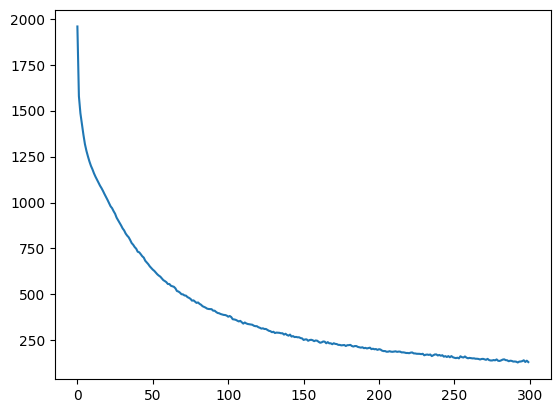

In [24]:
plt.plot(np.arange(len(loss_plt)),loss_plt)
plt.show()

In [26]:
# 预测函数
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])

    # 添加批量轴，即让batch_size = 1
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    # print(enc_X.shape)
    # return
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [28]:
# 评估函数
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score


In [29]:
# 测试训练效果
engs = ['I lost.', "I quit.", 'I\'m OK.']
fras = ['我迷失了。', '我退出。', '我沒事。']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

I lost. => 我 <unk> 它 <unk> 瑪, bleu 0.000
I quit. => 我 <unk> 它 <unk> 瑪, bleu 0.000
I'm OK. => 我 <unk> ？, bleu 0.000
